In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import utils

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input, TimeDistributed
from tensorflow.keras.layers import Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

tf.__version__
pd.__version__

'0.25.3'

In [2]:
os.listdir('./data')

['DJI_fe.csv',
 'DJI_STO_20period_sma10.csv',
 'N225.csv',
 'DJI_modified_features - DJI.csv',
 'N225fillVOL.csv',
 'DJI_modified_sma.csv',
 'downjone5y.csv',
 'N225withoutNULL.csv',
 'dowjone1985_2019.csv',
 '.ipynb_checkpoints',
 'DJI_ema.csv',
 'DJI_denoise.csv']

In [3]:
# data stats parameter
val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

# hyperparameter
batch_size = 256
epochs = 100
lr = 1e-3
decay = 1e-2

In [4]:
df = pd.read_csv('./data/DJI_fe.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Unnamed: 0.1', axis=1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sma_5,sma_10,sma_25,...,sma_125,sma_200,%K,%D,ema_5,ema_10,ema_25,ema_75,ema_125,ema_200
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1291.039998,1291.758179,1292.255380,1292.495258,1292.544757,1292.572831
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1289.616672,1290.851241,1291.833430,1292.344594,1292.453095,1292.515092
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1285.651105,1288.463737,1290.747779,1291.959736,1292.219235,1292.367876
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000,1287.013989,NaN,NaN,...,NaN,NaN,NaN,NaN,1287.127389,1288.757595,1290.696408,1291.910268,1292.185279,1292.345111


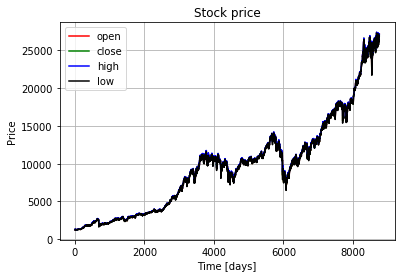

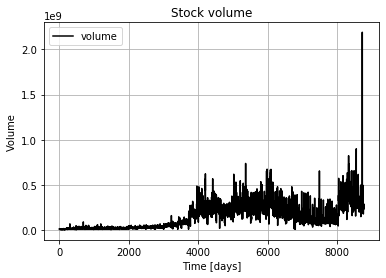

In [5]:
utils.plot_raw(df)

In [6]:
df = df.dropna()
df = df.drop('Date', axis=1)
df = df.drop('Adj Close', axis=1)
df = df.drop('Volume', axis=1)


cols = ['Open', 'Close', 'High', 'Low', '%K', '%D']
range_ma = [5, 10, 25, 75, 125, 200]
for ma in range_ma:
    cols.append('sma_' + str(ma))
    cols.append('ema_' + str(ma))

print(cols)
print(len(cols))


df_norm = utils.normalize_data(df,cols)

x_train, y_train, x_val, y_val, x_test, y_test = utils.load_data(df_norm)


['Open', 'Close', 'High', 'Low', '%K', '%D', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_25', 'ema_25', 'sma_75', 'ema_75', 'sma_125', 'ema_125', 'sma_200', 'ema_200']
18


/Users/2two2/Documents/MultimodelStockPrediction/utils.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data_raw = stock.as_matrix()


In [7]:
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (6835, 19, 18)
y_train.shape =  (6835, 18)
x_val.shape =  (854, 19, 18)
y_val.shape =  (854, 18)
x_test.shape =  (854, 19, 18)
y_test.shape =  (854, 18)


In [8]:
df.head()

,Open,High,Low,Close,sma_5,sma_10,sma_25,sma_75,sma_125,sma_200,%K,%D,ema_5,ema_10,ema_25,ema_75,ema_125,ema_200
199,0.000208,0.000243,0.000066,0.000226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.874862,0.911597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200,0.000269,0.000000,0.000000,0.000000,0.000188,0.000202,0.000158,0.000044,0.000048,0.000027,0.815671,0.905829,0.000135,0.000172,0.000146,0.000082,0.000058,0.000042
201,0.000000,0.000155,0.000049,0.000442,0.000495,0.000453,0.000331,0.000093,0.000097,0.000058,0.930889,0.914344,0.000373,0.000393,0.000315,0.000174,0.000123,0.000088
202,0.000389,0.000415,0.000244,0.000283,0.000732,0.000626,0.000479,0.000139,0.000138,0.000087,0.851183,0.902956,0.000478,0.000545,0.000459,0.000259,0.000184,0.000132
203,0.000292,0.000287,0.000111,0.000473,0.000795,0.000821,0.000612,0.000184,0.000180,0.000120,0.898578,0.903583,0.000612,0.000704,0.000606,0.000347,0.000248,0.000177


In [9]:
weight_path_model = "saved_model/model_sma_ema_sto.h5"
callbacks_list_model = [
    ModelCheckpoint(
             weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
]

In [10]:
K.clear_session()

def get_bi_lstm():
    
    input1 = Input(shape=(19,18,))
    x = LSTM(256, return_sequences=True)(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = LSTM(128)(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    out = Dense(18,activation='linear')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.summary()
    model.compile(optimizer=Adam(learning_rate=lr, decay=decay),
                loss='mse',
                metrics=['mse'])   
    
    return model

model = get_bi_lstm()

history = model.fit(x_train, y_train, epochs=epochs,
                   validation_data=(x_val, y_val), 
                   batch_size=batch_size, callbacks=callbacks_list_model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 18)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 19, 256)           281600    
_________________________________________________________________
time_distributed (TimeDistri (None, 19, 256)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 256)           1024      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512   

6656/6835 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 0.0025
Epoch 00022: val_loss improved from 0.02172 to 0.01946, saving model to saved_model/model_sma_ema_sto.h5
6835/6835 [==============================] - 10s 1ms/sample - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 23/100
6656/6835 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 0.0025
Epoch 00023: val_loss improved from 0.01946 to 0.01313, saving model to saved_model/model_sma_ema_sto.h5
6835/6835 [==============================] - 10s 1ms/sample - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 24/100
6656/6835 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 0.0024
Epoch 00024: val_loss improved from 0.01313 to 0.01057, saving model to saved_model/model_sma_ema_sto.h5
6835/6835 [==============================] - 10s 1ms/sample - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 25/100
6656/6835 [===========

Epoch 50/100
6656/6835 [============================>.] - ETA: 0s - loss: 0.0021 - mse: 0.0021
Epoch 00050: val_loss did not improve from 0.00473
6835/6835 [==============================] - 10s 1ms/sample - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 51/100
6656/6835 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0020
Epoch 00051: val_loss did not improve from 0.00473
6835/6835 [==============================] - 12s 2ms/sample - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 52/100
6656/6835 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0020
Epoch 00052: val_loss did not improve from 0.00473
6835/6835 [==============================] - 11s 2ms/sample - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 53/100
6656/6835 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0020
Epoch 00053: val_loss did not improve from 0.00473
6835/6835 [===========================

Epoch 80/100
6656/6835 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0018
Epoch 00080: val_loss did not improve from 0.00382
6835/6835 [==============================] - 10s 1ms/sample - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 81/100
6656/6835 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0018
Epoch 00081: val_loss did not improve from 0.00382
6835/6835 [==============================] - 12s 2ms/sample - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 82/100
6656/6835 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0018
Epoch 00082: val_loss did not improve from 0.00382
6835/6835 [==============================] - 11s 2ms/sample - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 83/100
6656/6835 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0018
Epoch 00083: val_loss improved from 0.00382 to 0.00361, saving model to saved_model/model

In [11]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

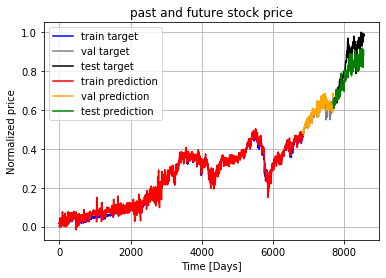

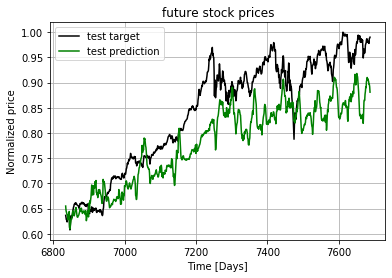

In [12]:
utils.plot_result(y_train, y_val, y_test, y_train_pred, y_val_pred, y_test_pred, ft=0)